In [1]:
exp_no = 4
sparsity = 0.1
gpu_id = 5

import torch
torch.cuda.set_device(gpu_id)

In [2]:
import os
import sys
import git
import pathlib

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

print(f"Project Root Directory: {PROJ_ROOT}")

Project Root Directory: /repos/drl_csense


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from typing import Any, Callable, Dict, Optional, Type, Union

In [6]:
import gymnasium as gym
from gymnasium import spaces

In [7]:
# from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.atari_wrappers import StickyActionEnv, NoopResetEnv, MaxAndSkipEnv, EpisodicLifeEnv, FireResetEnv, WarpFrame, ClipRewardEnv
from stable_baselines3.common.vec_env import VecFrameStack

from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [8]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [9]:
class SparseView(gym.ObservationWrapper[np.ndarray, int, np.ndarray]):
    def __init__(self, env: gym.Env, sparsity: float) -> None:
        super().__init__(env)
    def observation(self, frame: np.ndarray) -> np.ndarray:
        mask = self.np_random.choice(a=[False, True], size=frame.shape, p=[sparsity, 1.0-sparsity])
        sparse_frame = mask * frame
        return np.flipud(sparse_frame)

In [10]:
class MyAtariWrapper(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Atari 2600 preprocessings

    Specifically:

    * Noop reset: obtain initial state by taking random number of no-ops on reset.
    * Frame skipping: 4 by default
    * Max-pooling: most recent two observations
    * Termination signal when a life is lost.
    * Resize to a square image: 84x84 by default
    * Grayscale observation
    * Clip reward to {-1, 0, 1}
    * Sticky actions: disabled by default
    * Sparse image: some random pixels are blacked out

    See https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
    for a visual explanation.

    .. warning::
        Use this wrapper only with Atari v4 without frame skip: ``env_id = "*NoFrameskip-v4"``.

    :param env: Environment to wrap
    :param noop_max: Max number of no-ops
    :param frame_skip: Frequency at which the agent experiences the game.
        This correspond to repeating the action ``frame_skip`` times.
    :param screen_size: Resize Atari frame
    :param terminal_on_life_loss: If True, then step() returns done=True whenever a life is lost.
    :param clip_reward: If True (default), the reward is clip to {-1, 0, 1} depending on its sign.
    :param action_repeat_probability: Probability of repeating the last action
    """

    def __init__(
        self,
        env: gym.Env,
        noop_max: int = 30,
        frame_skip: int = 4,
        screen_size: int = 84,
        terminal_on_life_loss: bool = True,
        clip_reward: bool = True,
        action_repeat_probability: float = 0.0,
        sparsity = 0.0
    ) -> None:
        if action_repeat_probability > 0.0:
            env = StickyActionEnv(env, action_repeat_probability)
        if noop_max > 0:
            env = NoopResetEnv(env, noop_max=noop_max)
        # frame_skip=1 is the same as no frame-skip (action repeat)
        if frame_skip > 1:
            env = MaxAndSkipEnv(env, skip=frame_skip)
        if terminal_on_life_loss:
            env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():  # type: ignore[attr-defined]
            env = FireResetEnv(env)
        env = WarpFrame(env, width=screen_size, height=screen_size)
        env = SparseView(env, sparsity=sparsity)
        if clip_reward:
            env = ClipRewardEnv(env)

        super().__init__(env)

In [11]:
def make_my_atari_env(
    env_id: Union[str, Callable[..., gym.Env]],
    n_envs: int = 1,
    seed: Optional[int] = None,
    start_index: int = 0,
    monitor_dir: Optional[str] = None,
    wrapper_kwargs: Optional[Dict[str, Any]] = None,
    env_kwargs: Optional[Dict[str, Any]] = None,
    vec_env_cls: Optional[Union[Type[DummyVecEnv], Type[SubprocVecEnv]]] = None,
    vec_env_kwargs: Optional[Dict[str, Any]] = None,
    monitor_kwargs: Optional[Dict[str, Any]] = None,
    sparsity: Optional[float] = 0.0,
    ) -> VecEnv:
    """
    Create a wrapped, monitored VecEnv for Atari.
    It is a wrapper around ``make_vec_env`` that includes common preprocessing for Atari games.

    :param env_id: either the env ID, the env class or a callable returning an env
    :param n_envs: the number of environments you wish to have in parallel
    :param seed: the initial seed for the random number generator
    :param start_index: start rank index
    :param monitor_dir: Path to a folder where the monitor files will be saved.
        If None, no file will be written, however, the env will still be wrapped
        in a Monitor wrapper to provide additional information about training.
    :param wrapper_kwargs: Optional keyword argument to pass to the ``AtariWrapper``
    :param env_kwargs: Optional keyword argument to pass to the env constructor
    :param vec_env_cls: A custom ``VecEnv`` class constructor. Default: None.
    :param vec_env_kwargs: Keyword arguments to pass to the ``VecEnv`` class constructor.
    :param monitor_kwargs: Keyword arguments to pass to the ``Monitor`` class constructor.
    :return: The wrapped environment
    """
    return make_vec_env(
        env_id,
        n_envs=n_envs,
        seed=seed,
        start_index=start_index,
        monitor_dir=monitor_dir,
        wrapper_class=MyAtariWrapper,
        env_kwargs=env_kwargs,
        vec_env_cls=vec_env_cls,
        vec_env_kwargs=vec_env_kwargs,
        monitor_kwargs=monitor_kwargs,
        wrapper_kwargs=wrapper_kwargs,
    )

In [12]:
env_id = "BreakoutNoFrameskip-v4"
exp_tag = f"sparse_{sparsity}"
exp_name = f"{env_id}--{exp_tag}"

In [13]:
logfolder_root = pathlib.Path(PROJ_ROOT_PATH / "logging")

# Directory to save all training statistics
log_dir = pathlib.Path(logfolder_root / exp_name)
os.makedirs(log_dir, exist_ok=True)

# Directory to save gif animations
gif_dir = pathlib.Path(log_dir / "gifs" / exp_name)
os.makedirs(gif_dir, exist_ok=True)

# Directory to save models
models_dir = pathlib.Path(PROJ_ROOT_PATH / "models" / exp_name)
os.makedirs(models_dir, exist_ok=True)

In [14]:
# The different number of processes that will be used
NUM_ENVS = 16
TRAIN_STEPS = 5E7
# Number of episodes for evaluation
ALGO = A2C

In [15]:
mother_seed = 2023

In [16]:
# for experiment in range(NUM_EXPERIMENTS):
for experiment in [exp_no]:
    print("-------")
    print(f"RUN: {experiment}")
    # Log directory for each run of the experiment
    run_log_dir = f"{log_dir}/run_{experiment}"

    # Create the callback: check every 1000 steps
    callback = SaveOnBestTrainingRewardCallback(check_freq=1E4, 
                                                log_dir=run_log_dir,
                                                verbose=0)
    
    # Make vector environment
    env = make_my_atari_env(env_id,
                         n_envs=NUM_ENVS,
                         monitor_dir=run_log_dir,
                         seed=mother_seed+experiment,
                           sparsity = sparsity)
    
    # Frame-stacking with 4 frames
    env = VecFrameStack(env, n_stack=4)

    # Create RL model
    model = A2C("CnnPolicy", env, verbose=0)

    # Train the agent
    model.learn(total_timesteps=TRAIN_STEPS, 
                progress_bar=True, 
                callback=callback)

    # Save the final agent
    model.save(f"{models_dir}/{exp_name}-run_{experiment}")

-------
RUN: 4


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Output()

In [17]:
# Visualizing Results

In [18]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

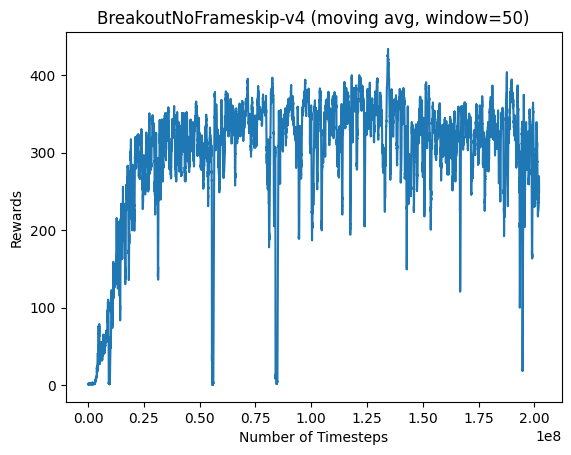

In [19]:
fig = plt.figure()
plt.xlabel("Number of Timesteps")
plt.ylabel("Rewards")
title = env_id
plt.title(title + " (moving avg, window=50)")
# for experiment in range(NUM_EXPERIMENTS):
for experiment in [exp_no]:
    run_log_dir = f"{log_dir}/run_{experiment}"
    x, y = ts2xy(load_results(run_log_dir), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]    
    plt.plot(x, y)  
plt.show()    